In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.nn.parameter import Parameter
import torchvision
from torchvision import transforms

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils
from SpykeTorch import makeInput

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

In [2]:
rf_size = 28 # Receptive field size that will be provided as input to the column
num_neurons = rf_size*rf_size # Number of excitatory neurons in the column
startposition = 0 # Start position of the receptive field w.r.t. top left corner of image
threshold = 75 # Firing threshold for every excitatory neuron
timesteps = 2 # Resolution for timesteps and weights

In [3]:
class PreProcTransform:
    def __init__(self, filter, timesteps = timesteps):
        self.to_tensor = transforms.ToTensor() # Convert to tensor
        self.filter = filter # Apply OnOff filtering
        self.temporal_transform = utils.Intensity2Latency(timesteps) # Convert pixel values to time
                                                    # Higher value corresponds to earlier spiketime
        self.crop = utils.Crop(startposition, rf_size) # Crop the image to form the receptive field
        
    def __call__(self, image):
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0) # Adds a temporal dimension at the beginning
        image = self.filter(image)
        temporal_image = self.temporal_transform(image)
        temporal_image = temporal_image.sign() # This will create spikes
        return self.crop(temporal_image)
    
kernels = [utils.OnKernel(3), utils.OffKernel(3)]
inchannels = len(kernels)

filter = utils.Filter(kernels, padding = 2, thresholds = 50)
preproc = PreProcTransform(filter)

In [13]:
data_root = "data"
MNIST_train = utils.CacheDataset(torchvision.datasets.MNIST(root=data_root, train=True, download=True, transform = preproc))
MNIST_test = utils.CacheDataset(torchvision.datasets.MNIST(root=data_root, train=False, download=True, transform = preproc))
MNIST_trainLoader = DataLoader(MNIST_train, batch_size=1000, shuffle=True)
MNIST_testLoader = DataLoader(MNIST_test, batch_size=1000, shuffle=True)
#Single Training Example
num_img=1000
zero_mask = makeInput.makeMask(0,num_img)
one_mask = makeInput.makeMask(1,num_img)
two_mask = makeInput.makeMask(2,num_img)
three_mask = makeInput.makeMask(3,num_img)
four_mask = makeInput.makeMask(4,num_img)
five_mask = makeInput.makeMask(5,num_img)
six_mask = makeInput.makeMask(6,num_img)
seven_mask = makeInput.makeMask(7,num_img)
eight_mask = makeInput.makeMask(8,num_img)
nine_mask = makeInput.makeMask(9,num_img)
#plt.imshow(input.mask[0], cmap='gray_r')

print(type(zero_mask))

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:01, 9741462.31it/s]                             


Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw


32768it [00:00, 299313.89it/s]                           
0it [00:00, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw


1654784it [00:00, 3290652.43it/s]                            
8192it [00:00, 108331.22it/s]


Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw
Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw
Processing...
Done!
93  images in numpy array with shape  (93, 28, 28)
117  images in numpy array with shape  (117, 28, 28)
96  images in numpy array with shape  (96, 28, 28)
107  images in numpy array with shape  (107, 28, 28)
95  images in numpy array with shape  (95, 28, 28)
99  images in numpy array with shape  (99, 28, 28)
111  images in numpy array with shape  (111, 28, 28)
97  images in numpy array with shape  (97, 28, 28)
89  images in numpy array with shape  (89, 28, 28)
99  images in numpy array with shape  (99, 28, 28)
<class 'numpy.ndarray'>


In [17]:
#Create Dataset - shape is list of image examples where each example is [data, label]

train_dataset=list() #shape = (1x2x784)
num_training=1

for i in range(0,num_training): 
    train_dataset.append(torch.as_tensor(np.concatenate(zero_mask[i])))

# for i in range(0,num_training):
#     train_dataset.append(np.concatenate(one_mask[i]))
    
# for i in range(0,num_training): 
#     train_dataset.append(np.concatenate(two_mask[i]))

# for i in range(0,num_training):
#      train_dataset.append(np.concatenate(three_mask[i]))
    
# for i in range(0,num_training): 
#      train_dataset.append(np.concatenate(four_mask[i]))

# for i in range(0,num_training):
#     train_dataset.append(np.concatenate(five_mask[i]))
    
# for i in range(0,num_training): 
#      train_dataset.append(np.concatenate(six_mask[i]))

# for i in range(0,num_training):
#     train_dataset.append(np.concatenate(seven_mask[i]))
    
# for i in range(0,num_training): 
#      train_dataset.append(np.concatenate(eight_mask[i]))

# for i in range(0,num_training):
#      train_dataset.append(np.concatenate(nine_mask[i]))

print(len(train_dataset))

1


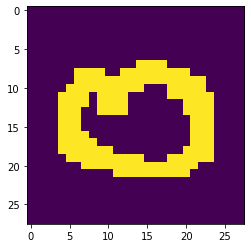

In [20]:
plt.imshow(MNIST_train[1][0][1][0])

In [21]:
class Column(nn.Module):
    def __init__(self):
        super(Column, self).__init__()
        # Local Convolution layer which creates columns with unique weights (NOT shared weights). The
        # number of columns is based on input_size, kernel_size and stride. Here since we are simulating
        # only one column, the input_size and kernel_size are kept same.
        self.ec = snn.HopfieldNetwork()
        # STDP module which implements the given STDP rule for the above layer (a single column in this case)
        self.stdp = snn.ModSTDP(self.ec, 10/128, 10/128, 1/128, 96/128, 4/128, maxweight = timesteps)
        
    def forward(self, rec_field, threshold):
        ### Start of Excitatory Column ###
        out = self.ec(rec_field,threshold)
        #spike, pot = sf.fire(out, threshold, True)
        ### End of Excitatory Column ###
        ### Start of Lateral Inhibition ###
        #out = sf.pointwise_inhibition(pot).sign()
        ### End of Lateral Inhibition ###
        return out

In [22]:
# for epochs in range(1):
#     start = time.time()
#     for data, target in MNIST_trainLoader:
#         for i in range(len(data)):
#             # Passing data through the column
#             out = MyColumn(data[i])
#             # STDP training for each input is performed here
#             MyColumn.stdp(data[i],out)
#     end = time.time()
#     print("Training done under ", end-start)
MyColumn=Column()
MyColumn.ec.train_weights(MNIST_train[0][0][0])
plt.imshow(MNIST_train[0][0][0][0])

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

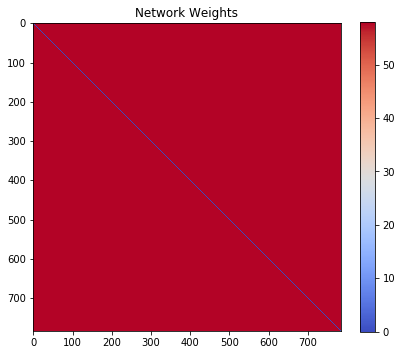

In [8]:
plt.figure(figsize=(6, 5))
w_mat = plt.imshow(MyColumn.ec.W, cmap=cm.coolwarm)
plt.colorbar(w_mat)
plt.title("Network Weights")
plt.tight_layout()
plt.savefig("weights.png")
plt.show()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 

tensor([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 

tensor([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

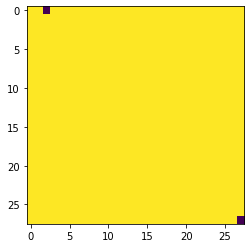

In [10]:
plt.imshow(MyColumn(MNIST_train[1][0][1][0].reshape(784).unsqueeze(0),75)[0][0])

In [16]:
table    = torch.zeros((num_neurons,10))
pred     = torch.zeros(num_neurons)
totals   = torch.zeros(num_neurons)

count = 0
for data, target in MNIST_testLoader:
    for i in range(len(data)):
        count += 1
        out = MyColumn(data[i]).squeeze()
        out = torch.sum(out,0)
        temp = torch.nonzero(out)
        if temp.size(0) != 0:
            table[temp[0][0], target[i]] += 1
            
print("Confusion Matrix:")
print(table)

maxval = torch.max(table, 1)[0]
totals = torch.sum(table, 1)
pred = torch.sum(maxval)
covg_cnt = torch.sum(totals)

print("Purity: ", pred/covg_cnt)
print("Coverage: ", covg_cnt/count)

TypeError: forward() missing 1 required positional argument: 'threshold'